In [1]:
# Load dataframes

import pandas as pd

ESN = pd.read_csv('../content/csv/FINALDATASET_EastSlopesNorth.csv')
WSN = pd.read_csv('../content/csv/FINALDATASET_WestSlopesNorth.csv')
WSS = pd.read_csv('../content/csv/FINALDATASET_WestSlopesSouth.csv')

assert all(ESN.columns) == all(WSN.columns) and all(ESN.columns) == all(WSS.columns), \
    'All dataframes should have the same columns'

In [2]:
# Combine dataframes

DATA = pd.concat([ESN, WSN, WSS], axis=0, ignore_index=True)

# Show any rows with NaN
DATA[DATA.isna().any(axis=1)]

# Todo: try dropping NaN columns instead
DATA.fillna(DATA.mean(), inplace=True)

# Todo: should we try to use these?
DATA.drop(['Date', 'Area'], axis=1, inplace=True)

# Try normalizing: does not help
# for col in DATA.columns:
    # DATA[col] = (DATA[col]-DATA[col].mean())/DATA[col].std()
# DATA=(DATA-DATA.min())/(DATA.max()-DATA.min())

# Can uncomment to make prediction better
DATA.drop(['Yesterday Danger Above Treeline', 'Yesterday Danger At Treeline', 'Yesterday Danger Below Treeline'], axis=1, inplace=True)

/tmp/ipykernel_20046/3531423699.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  DATA.fillna(DATA.mean(), inplace=True)


In [3]:
DATA.columns

Index(['Above Treeline', 'At Treeline', 'Below Treeline', 'Max Air Temp 24hr',
       'Total Snowfall 24hr', 'Delta SWE 24hr', 'Min Temp Diff 48hr',
       'Max Windspeed 24hr', 'Was High Winds 24hr', 'Max Air Temp 72hr',
       'Total Snowfall 72hr', 'Weighted Snowfall 96hr',
       'Was Heavy Snowfall 24hr', 'Sum Max Temp 72hr'],
      dtype='object')

In [4]:
# Make some predictions!

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

def make_prediction_rfr(df, y_col):
    x = df.drop(y_col, axis=1)
    y = df[y_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

    rf_regressor = RandomForestRegressor(random_state=42)

    rf_regressor.fit(x_train, y_train)

    y_pred_train = rf_regressor.predict(x_train)
    y_pred = rf_regressor.predict(x_test)

    print(y_col)
    print('\tPrediction score:', '{0:.2f}'.format(r2_score(y_train, y_pred_train)), \
          'Actual score:', '{0:.2f}'.format(r2_score(y_test, y_pred)))

above_treeline = DATA.drop(['At Treeline', 'Below Treeline'], axis=1)
at_treeline = DATA.drop(['Above Treeline', 'Below Treeline'], axis=1)
below_treeline = DATA.drop(['Above Treeline', 'At Treeline'], axis=1)

make_prediction_rfr(above_treeline, 'Above Treeline')
make_prediction_rfr(at_treeline, 'At Treeline')
make_prediction_rfr(below_treeline, 'Below Treeline')

Above Treeline
	Prediction score: 0.85 Actual score: 0.24
At Treeline
	Prediction score: 0.85 Actual score: 0.25
Below Treeline
	Prediction score: 0.86 Actual score: 0.12


/tmp/ipykernel_20046/4096089072.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(DATA.corr(), dtype=np.bool))


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

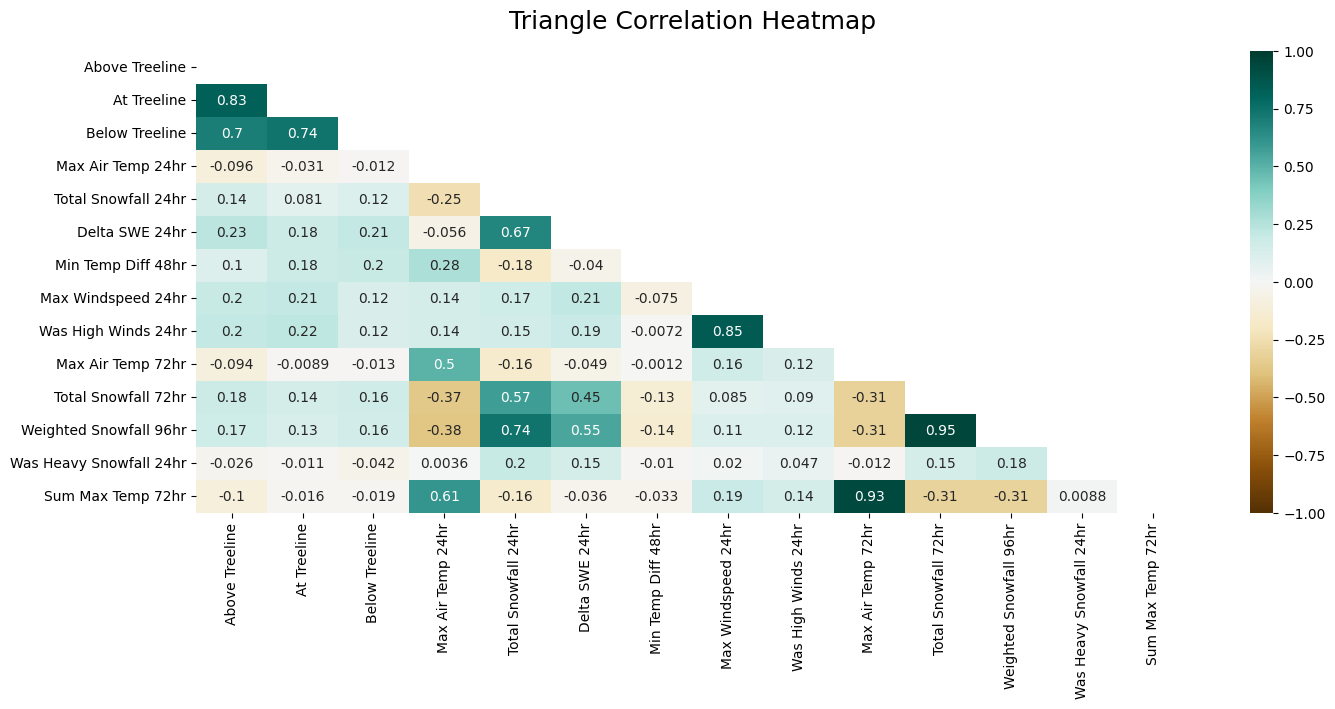

In [5]:
# Make another correlation matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
mask = np.triu(np.ones_like(DATA.corr(), dtype=np.bool))
heatmap=sns.heatmap(DATA.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)

In [6]:
# Try to improve score by dropping columns


def get_r2_score(training_data):
    """Returns training score, actual score"""
    drop = 'At Treeline'
    x = training_data.drop(drop, axis=1)
    y = training_data[drop]

    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

    rf_regressor = RandomForestRegressor(random_state=42)
    rf_regressor.fit(x_train, y_train)

    y_pred_train = rf_regressor.predict(x_train)
    y_pred = rf_regressor.predict(x_test)


    return r2_score(y_train, y_pred_train), r2_score(y_test, y_pred)

def find_bad_col(df):
    max_r2 = get_r2_score(df)[1]
    bad_col = None
    for col in df.columns[1:]:
        training, actual = get_r2_score(df.drop([col], axis=1))
        if actual > max_r2:
            max_r2 = actual
            bad_col = col
    print('Increased r2 to:', max_r2, 'by deleting:', bad_col)

find_bad_col(at_treeline)
next_df = at_treeline.drop('Total Snowfall 24hr', axis=1)
find_bad_col(next_df)
next_df = next_df.drop('Total Snowfall 72hr', axis=1)
find_bad_col(next_df)

Increased r2 to: 0.26699758764582715 by deleting: Total Snowfall 24hr
Increased r2 to: 0.27826505239804566 by deleting: Total Snowfall 72hr
Increased r2 to: 0.27826505239804566 by deleting: None


In [7]:
# Try KNN, because that^ is not a good prediction

NORMALIZED = DATA.copy(deep=True)
for col in NORMALIZED.columns:
    if col not in (
        'Above Treeline',
        'At Treeline', 
        'Below Treeline'
        'Was High Winds 24hr', 
        'Was Heavy Snowfall 24hr'):
        NORMALIZED[col] = (NORMALIZED[col]-NORMALIZED[col].mean())/NORMALIZED[col].std()
# NORMALIZED=(NORMALIZED-NORMALIZED.min())/(NORMALIZED.max()-NORMALIZED.min())

In [8]:
from sklearn.model_selection import train_test_split

x = NORMALIZED.drop(['Above Treeline', 'At Treeline', 'Below Treeline'], axis=1)
y = NORMALIZED['At Treeline']

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=24) 

model.fit(x_training_data, y_training_data)

predictions = model.predict(x_test_data)

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           1       0.50      0.07      0.12        14
           2       0.55      0.94      0.70        50
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00         5

    accuracy                           0.54        89
   macro avg       0.26      0.25      0.21        89
weighted avg       0.39      0.54      0.41        89



/home/alyo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alyo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alyo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


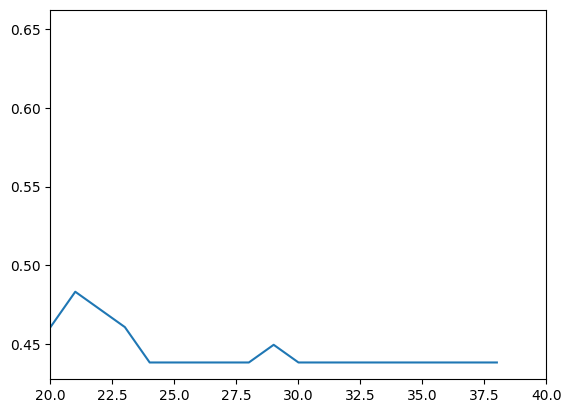

In [11]:
error_rates = []

xmax = 40
for i in np.arange(1, xmax): # 101

    new_model = KNeighborsClassifier(n_neighbors = i)

    new_model.fit(x_training_data, y_training_data)

    new_predictions = new_model.predict(x_test_data)

    error_rates.append(np.mean(new_predictions != y_test_data))

plt.xlim(20, xmax)
plt.plot(error_rates)

In [12]:


predicted = model.predict(NORMALIZED.drop(['Above Treeline', 'At Treeline', 'Below Treeline'], axis=1))
actual = NORMALIZED['At Treeline']
assert len(predicted) == len(actual)
over_predict = 0
under_predict = 0
way_off = 0
for i in range(len(actual)):
    p = predicted[i]
    a = actual[i]
    diff = a - p
    if diff == 1:
        under_predict += 1
    if diff == -1:
        over_predict += 1
    if diff < -1 or diff > 1:
        way_off += 1
        print('WAY off: predicted:', p, 'actual:', a)
under_pct = '{0:.2f}'.format(under_predict * 100.0 / len(actual))
over_pct = '{0:.2f}'.format(over_predict * 100.0 / len(actual))
way_pct = '{0:.2f}'.format(way_off * 100.0 / len(actual))
print('Predicted less dangerous than actual:', under_predict, f'{under_pct}%')
print('Predicted more dangerous than actual:', over_predict, f'{over_pct}%')
print('WAY off:', way_off, f'{way_pct}%')

WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
WAY off: predicted: 2 actual: 4
Predicted less dangerous than actual: 99 22.45%
Predicted more dangerous than actual: 66 14.97%
WAY off: 15 3.40%
